We often try to predict the price of an asset from its observable characteristics. This is generally called hedonic pricing: How do the unit's characteristics determine its market price?

1. Clean the data and perform some EDA and visualization to get to know the data set.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

In [3]:
df = pd.read_csv("airbnb_hw.csv")
df.head()

,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
0,5162530,NaN,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire home/apt,11249.0,1.0,1,0,145,NaN
1,33134899,NaN,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,1,37,NaN
2,39608626,NaN,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,1,28,NaN
3,500,6/26/2008,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire home/apt,10024.0,3.0,1,0,199,NaN
4,500,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0


In [4]:
# Data Cleaning
# Convert 'Price' to numeric
df["Price"] = df["Price"].replace(r"[^\d.]", "", regex=True).astype(float)


In [5]:
# Convert 'Host Since' to datetime
df["Host Since"] = pd.to_datetime(df["Host Since"], errors="coerce")

In [6]:
# Fill missing values
df["Beds"].fillna(df["Beds"].median(), inplace=True)
df["Zipcode"].fillna(df["Zipcode"].mode()[0], inplace=True)
df["Review Scores Rating"].fillna(df["Review Scores Rating"].median(), inplace=True)
df.dropna(subset=["Property Type"], inplace=True)

<ipython-input-6-df2ec126d408>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Beds"].fillna(df["Beds"].median(), inplace=True)
<ipython-input-6-df2ec126d408>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

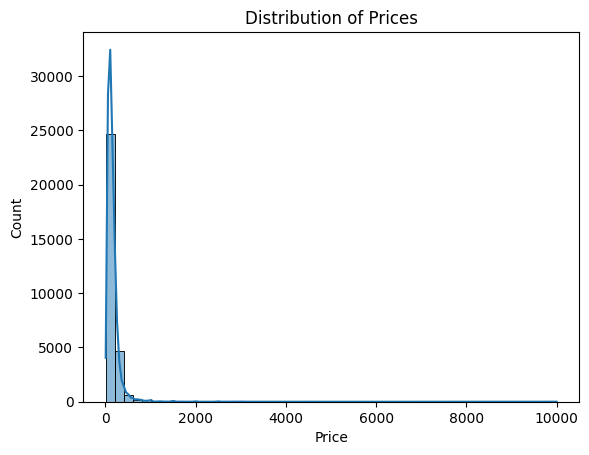

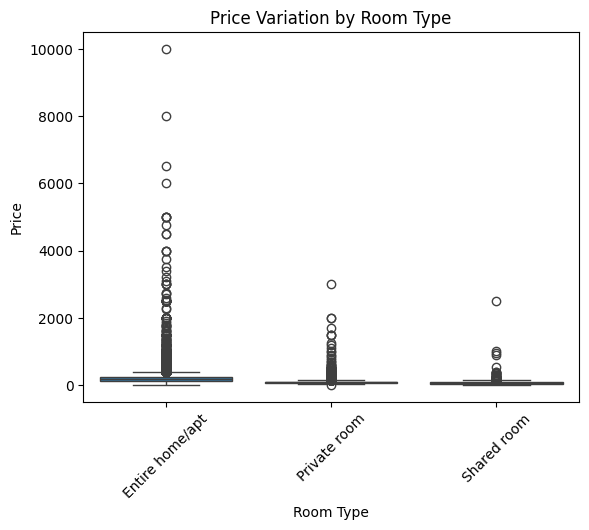

In [7]:
# Step 1: Exploratory Data Analysis
sns.histplot(df["Price"], bins=50, kde=True)
plt.title("Distribution of Prices")
plt.show()


sns.boxplot(x="Room Type", y="Price", data=df)
plt.xticks(rotation=45)
plt.title("Price Variation by Room Type")
plt.show()

In [12]:
# Step 2: Transform categorical variables
df = pd.get_dummies(df, columns=["Neighbourhood ", "Property Type", "Room Type"], drop_first=True)

In [10]:
print(df.columns.tolist())


['Host Id', 'Host Since', 'Name', 'Neighbourhood ', 'Property Type', 'Review Scores Rating (bin)', 'Room Type', 'Zipcode', 'Beds', 'Number of Records', 'Number Of Reviews', 'Price', 'Review Scores Rating']


In [13]:
# Step 3: Train-Test Split
X = df.drop(columns=["Price", "Name", "Host Id", "Host Since"])
y = df["Price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Impute missing values in X_train and X_test using SimpleImputer (had to do this before step 4)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')


X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [16]:
# Step 4: Simple Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Model evaluation
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training RMSE: {train_rmse}, Training R^2: {train_r2}")
print(f"Test RMSE: {test_rmse}, Test R^2: {test_r2}")

Training RMSE: 175.22704556033628, Training R^2: 0.19275457361174075
Test RMSE: 187.0949707418948, Test R^2: 0.19457928985903117


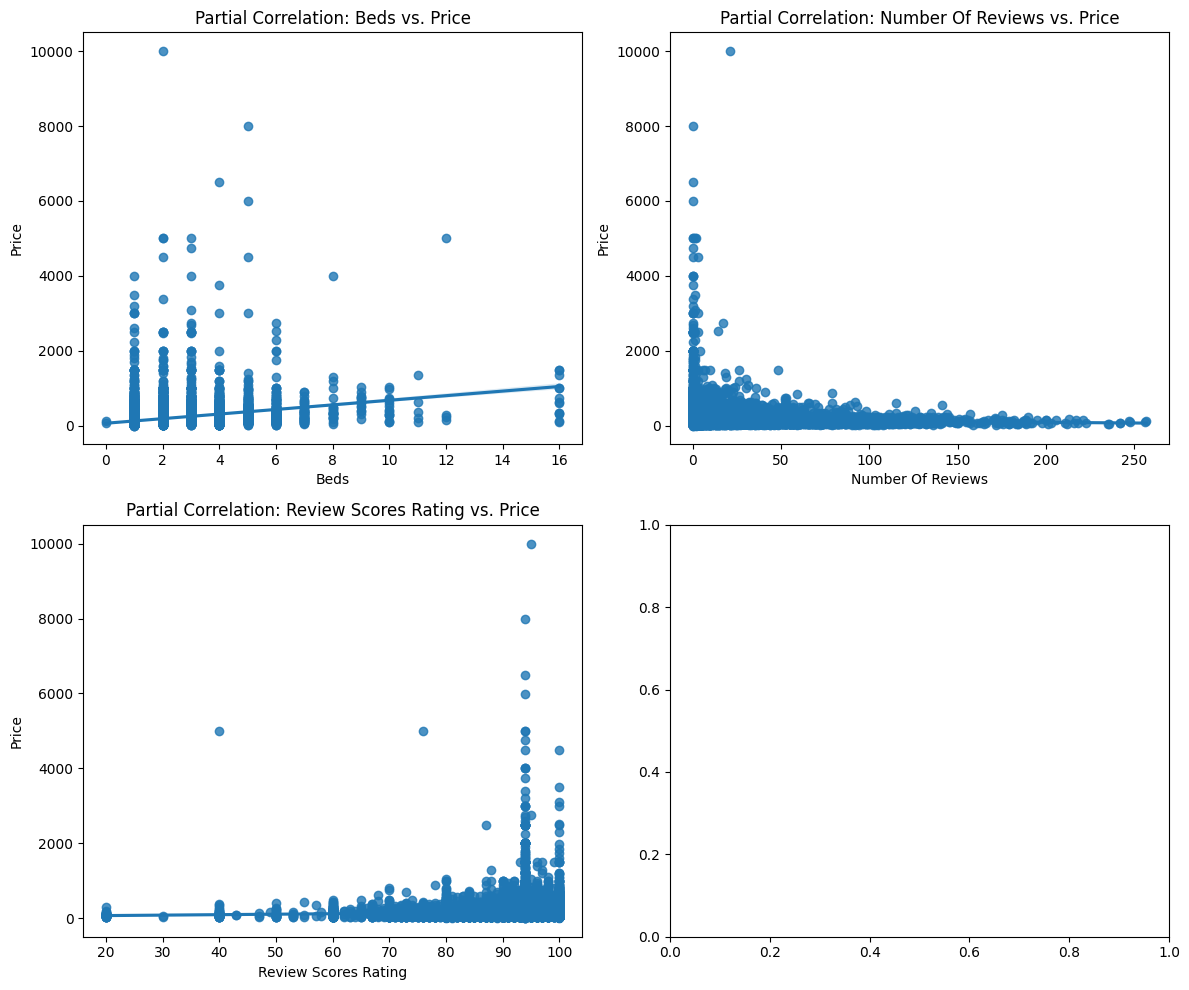

In [17]:
# Step 5: Partial correlation plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
numeric_vars = ["Beds", "Number Of Reviews", "Review Scores Rating"]
for i, var in enumerate(numeric_vars):
    row, col = divmod(i, 2)
    sns.regplot(x=df[var], y=df["Price"], ax=axes[row, col])
    axes[row, col].set_title(f"Partial Correlation: {var} vs. Price")
plt.tight_layout()
plt.show()


In [19]:
# Step 6: Complex Model with Interactions
# Get the column indices for 'Beds' and 'Number Of Reviews' from the original DataFrame columns
beds_index = df.columns.get_loc("Beds")
reviews_index = df.columns.get_loc("Number Of Reviews")

# Use these indices to create the interaction term in the NumPy arrays
X_train = np.concatenate([X_train, (X_train[:, beds_index] * X_train[:, reviews_index])[:, np.newaxis]], axis=1)
X_test = np.concatenate([X_test, (X_test[:, beds_index] * X_test[:, reviews_index])[:, np.newaxis]], axis=1)

# Now you can fit the complex model
lr_complex = LinearRegression()
lr_complex.fit(X_train, y_train)
y_train_pred_complex = lr_complex.predict(X_train)
y_test_pred_complex = lr_complex.predict(X_test)

In [21]:
# Evaluate complex model
train_rmse_complex = np.sqrt(mean_squared_error(y_train, y_train_pred_complex))
test_rmse_complex = np.sqrt(mean_squared_error(y_test, y_test_pred_complex))
train_r2_complex = r2_score(y_train, y_train_pred_complex)
test_r2_complex = r2_score(y_test, y_test_pred_complex)

print(f"Complex Model Training RMSE: {train_rmse_complex}, R^2: {train_r2_complex}")
print(f"Complex Model Test RMSE: {test_rmse_complex}, R^2: {test_r2_complex}")

Complex Model Training RMSE: 175.1848861192522, R^2: 0.19314297166675143
Complex Model Test RMSE: 187.09370574000923, R^2: 0.19459018117554883


In [22]:
# Step 7: Summary
print("\nModel Comparison:")
print(f"Simple Model - Train R^2: {train_r2}, Test R^2: {test_r2}")
print(f"Complex Model - Train R^2: {train_r2_complex}, Test R^2: {test_r2_complex}")

if train_r2_complex > train_r2 and test_r2_complex > test_r2:
    print("The complex model performs better than the simple model.")
else:
    print("The simple model may be sufficient, avoiding overfitting.")



Model Comparison:
Simple Model - Train R^2: 0.19275457361174075, Test R^2: 0.19457928985903117
Complex Model - Train R^2: 0.19314297166675143, Test R^2: 0.19459018117554883
The complex model performs better than the simple model.


Results: In this analysis, I explored hedonic pricing using Airbnb data. The simple linear regression model had a training R² of 0.1928 and a test R² of 0.1946, while the more complex model, which included interactions, slightly improved performance with a training R² of 0.1931 and a test R² of 0.1946.

Cleaning the data and encoding categorical variables helped prepare the dataset for regression analysis. The complex model performed marginally better, but the improvement was minimal. This suggests that the additional interactions and transformations did not significantly enhance predictive power. Additionally, since the training and test R² values remained nearly identical between models, the complex model did not overfit, but it also did not capture substantially more variance. The relatively low R² values indicate that important features influencing price may be missing. Furthermore, the small performance gain from the complex model suggests that a simpler model might be preferable for interpretability, especially since it avoids unnecessary complexity without a significant trade-off in accuracy.